# Example 3: Dyanmo with Forcing
This example aim to show the implmentation of force module using the MHD solver. The idea of force module is coming from [ApJ..626..853](https://ui.adsabs.harvard.edu/abs/2005ApJ...626..853M/abstract) but more simplified version in this notebook. 

The result of interation between the force and velocity field would resulting the amplification of weak magnetic field, which usually called the dynamo effect. The example is running on GPU with the resolution of $64^3$. Beaware that the result may not converge on higher resolution, which require the modification of the force module. 

In [1]:
using MHDFlows,PyPlot,CUDA
using LinearAlgebra: mul!, ldiv!

┌ Info: FourierFlows will use 8 threads
└ @ FourierFlows /home/doraho/.julia/packages/FourierFlows/2BZya/src/FourierFlows.jl:123


In [2]:
device()

CuDevice(0): NVIDIA GeForce RTX 3080

In [3]:
#force module
#GPU version
function AddForceGPU!(N, sol, t, clock, vars, params, grid)
    # ∂u_ih∂t + Fv_TG, here we assume F is some constant
    F0 = 1.37;
    N0 = grid.nx;
    l = 2;
    T = eltype(grid);
    fx,fy,fz = zeros(T,N0,N0,N0),zeros(T,N0,N0,N0),zeros(T,N0,N0,N0);
    # Real Space Computation of force function
    for k ∈ 1:N0, j ∈ 1:N0, i ∈ 1:N0
        xx = l*grid.x[i];
        yy = l*grid.y[j];
        zz = l*grid.z[k];
        # f = F*v_TG
        fx[i,j,k] =   sin(xx)*cos(yy)*cos(zz);
        fy[i,j,k] =  -cos(xx)*sin(yy)*cos(zz);
        fz[i,j,k] =  0;
    end

    for (u_ind,f_i) ∈ zip([params.ux_ind,params.uy_ind,params.uz_ind],[fx,fy,fz])
        @. vars.nonlinh1*=0;
        copyto!(vars.nonlin1, F0.*f_i);
        fk_i = vars.nonlinh1;
        @. fk_i*=0;
        mul!(fk_i, grid.rfftplan, vars.nonlin1);  
        @. N[:,:,:,u_ind] += fk_i;
    end
end

AddForceGPU! (generic function with 1 method)

In [4]:
#parameters
N = 64;
Lx = 2π;
ν,η = 2e-3,5e-3;
dt = 1/50;

# Testing the problem
# Declare the problem on GPU
GPUprob  = Problem(GPU();nx = N,
                         Lx = Lx,
                          ν = ν,
                         nν = 1,
                       #B-field 
                    B_field = true,
           # Timestepper and equation options
                         dt = dt,
                    stepper = "RK4",
                      calcF = AddForceGPU!,
           # Float type and dealiasing
                          T = Float32);
GPUprob

MHDFlows Problem
  │    Funtions
  │     ├──────── B-field: ON
  ├─────├────── VP Method: OFF
  │     ├──────────── Dye: OFF
  │     └── user function: OFF
  │                        
  │     Features           
  │     ├─────────── grid: grid (on GPU)
  │     ├───── parameters: params
  │     ├────── variables: vars
  └─────├─── state vector: sol
        ├─────── equation: eqn
        ├────────── clock: clock
        └──── timestepper: RK4TimeStepper

In [5]:
function ProblemGeneratorTG!(prob,L0,N)

  # Output Setting  
  xx,yy,zz = fill(0.0,N,N,N),fill(0.0,N,N,N),fill(0.0,N,N,N);
  
 l = 2*2*π/L0;    
  for k ∈ 1:N, j ∈ 1:N, i ∈ 1:N
    xx[i,j,k] = l*prob.grid.x[i];
    yy[i,j,k] = l*prob.grid.y[j];
    zz[i,j,k] = l*prob.grid.z[k];
  end
    
  ux = @.  sin(xx)*cos(yy)*cos(zz);
  uy = @.  -cos(xx)*sin(yy)*cos(zz);
  uz = @.  fill(0.0,N,N,N);

  bx = @. sqrt(1e-3)*ux;
  by = @. sqrt(1e-3)*uy;
  bz = @. sqrt(1e-3)*uz;        
    
  copyto!(prob.vars.ux, ux);
  copyto!(prob.vars.uy, uy);
  copyto!(prob.vars.uz, uz);
  copyto!(prob.vars.bx, bx);
  copyto!(prob.vars.by, by);
  copyto!(prob.vars.bz, bz);

  #Update V + B Fourier Conponment
  uxh = prob.sol[:, :, :, prob.params.ux_ind];
  uyh = prob.sol[:, :, :, prob.params.uy_ind];
  uzh = prob.sol[:, :, :, prob.params.uz_ind];
    
  bxh = prob.sol[:, :, :, prob.params.bx_ind];
  byh = prob.sol[:, :, :, prob.params.by_ind];
  bzh = prob.sol[:, :, :, prob.params.bz_ind];

  mul!(uxh, prob.grid.rfftplan, prob.vars.ux);   
  mul!(uyh, prob.grid.rfftplan, prob.vars.uy);
  mul!(uzh, prob.grid.rfftplan, prob.vars.uz);
  mul!(bxh, prob.grid.rfftplan, prob.vars.bx);
  mul!(byh, prob.grid.rfftplan, prob.vars.by);
  mul!(bzh, prob.grid.rfftplan, prob.vars.bz);
    
  prob.sol[:, :, :, prob.params.ux_ind] .= uxh;
  prob.sol[:, :, :, prob.params.uy_ind] .= uyh;
  prob.sol[:, :, :, prob.params.uz_ind] .= uzh;
  prob.sol[:, :, :, prob.params.bx_ind] .= bxh;
  prob.sol[:, :, :, prob.params.by_ind] .= byh;
  prob.sol[:, :, :, prob.params.bz_ind] .= bzh;
      
  return nothing
end

ProblemGeneratorTG! (generic function with 1 method)

In [6]:
#function for monitoring the energy
function KEfoo(prob)
    vx,vy,vz = prob.vars.ux,prob.vars.uy,prob.vars.uz;
    return sum(vx.^2+vy.^2 + vz.^2)
end

function MEfoo(prob)
    bx,by,bz = prob.vars.bx,prob.vars.by,prob.vars.bz;
    return sum(bx.^2+by.^2 + bz.^2)
end

KE = Diagnostic(KEfoo, GPUprob);
ME = Diagnostic(MEfoo, GPUprob);

In [7]:
#GPU for 64^3
L0 = 2;
ProblemGeneratorTG!(GPUprob,L0,N)

CUDA.@time TimeIntegrator!(GPUprob,20.0,1000;
                   usr_dt = dt,
                    diags = [KE,ME],
              loop_number = 100,
                     save = false,
                 save_loc = "",
                 filename = "",
                  dump_dt = 0)

n = 100, t =      2.0, KE =    391.0, ME=     3.97
n = 200, t =      4.0, KE =    402.0, ME=    197.0
n = 300, t =      6.0, KE =    378.0, ME=    214.0
n = 400, t =      8.0, KE =    376.0, ME=    208.0
n = 500, t =     10.0, KE =    370.0, ME=    206.0
n = 600, t =     12.0, KE =    369.0, ME=    203.0
n = 700, t =     14.0, KE =    368.0, ME=    203.0
n = 800, t =     16.0, KE =    372.0, ME=    206.0
n = 900, t =     18.0, KE =    364.0, ME=    214.0
n = 1000, t =     20.0, KE =    364.0, ME=    217.0
 79.929198 seconds (86.41 M CPU allocations: 53.122 GiB, 3.17% gc time) (116.14 k GPU allocations: 112.589 GiB, 0.61% memmgmt time)


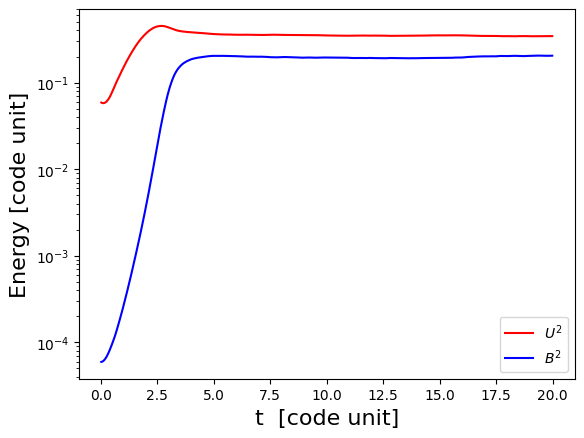

PyObject Text(30.000000000000014, 0.5, 'Energy [code unit]')

In [8]:
t  = KE.t[2:end-10];
uu = KE.data[2:end-10];
bb = ME.data[2:end-10];

semilogy(t,uu.*(GPUprob.grid.dx)^6,"r",label=L"U^2")
semilogy(t,bb.*(GPUprob.grid.dx)^6,"b",label=L"B^2")
legend()
xlabel("t  [code unit]",size=16)
ylabel("Energy [code unit]",size=16)